In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import torch
from torchvision.datasets import ImageNet
from torchvision import transforms
from torchvision.transforms import functional as F
import torch.nn.functional as batch
import torchvision
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from random import random
import torch.multiprocessing as mp
from torch.utils.data import random_split, DataLoader, Subset

from csng.imagenet.models import ResnetExtractor, UpsampleModel, count_parameters



Using cache found in /home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
/home/vanousek/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


# Weight decay


In [2]:
# Define the image limit
BATCH_SIZE = 64

TRAIN_SIZE = 500 * BATCH_SIZE
TEST_SIZE = 20 * BATCH_SIZE
LOSS_EVERY = 5
EPOCHS = 1
SPLIT = 'train'
WEIGHT_DECAY=5e-3
LEARNING_RATE = .00005

device = os.environ["DEVICE"]

DATA_DIR = os.environ['DATA_PATH']
CACHE_DIR = join(DATA_DIR, 'imagenet_inversion')
RESNET_SIZE = 224


class CachedImageNet(ImageNet):
    def __init__(self, root, split, version='0.1'):
        TRANSFORM = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
        super().__init__(root=root, split=split, transform=TRANSFORM)
        self.cache_dir = os.path.join(CACHE_DIR, version, split)

        # Create cache directory if it doesn't exist
        os.makedirs(self.cache_dir, exist_ok=True)
        self.resnet_extractor = None

    def get_extractor(self):
        if self.resnet_extractor is None:
            self.resnet_extractor = ResnetExtractor()
        return self.resnet_extractor

    def _get_cache_path(self, index):
        """Get the path for the cached feature."""
        return os.path.join(self.cache_dir, f'feature_{index}.pt')

    def __getitem__(self, index):
        # Load the image and label
        img, object_class = super().__getitem__(index)

        cache_path = self._get_cache_path(index)
        features = None
        if not os.path.exists(cache_path):
            # # Image transformations
            # if os.path.exists(cache_path):
            #     saved_features = torch.load(cache_path).to(device)
            #     assert torch.equal(features,saved_features)
            features = self.get_extractor().get_features(img)
            self.save_atomic(features, cache_path)
        else:
            features = torch.load(cache_path).to(device)

        target = F.rgb_to_grayscale(img, num_output_channels=1)
        return features, target
    def save_atomic(self, value, name):
        tmp_name = name + '.tmp' + str(random())
        torch.save(value, tmp_name)
        os.replace(tmp_name, name)
# Example feature extractor: compute mean/std per channel



# Set the start method to 'spawn'
mp.set_start_method('spawn', force=True)
# Initialize CachedImageNet
train_dataset = CachedImageNet(
    root=join(DATA_DIR, 'imagenet'),
    split=SPLIT,
    version='1.1'
)


assert(len(train_dataset) >= TRAIN_SIZE + TEST_SIZE)

# Define the split sizes

# Split the dataset within the limit
train_subset_indices = list(range(TRAIN_SIZE))  # Indices for the training subset
test_subset_indices = list(range(TRAIN_SIZE, TRAIN_SIZE + TEST_SIZE))  # Indices for the test subset

# Create the subsets
train_subset = Subset(train_dataset, train_subset_indices)
test_subset = Subset(train_dataset, test_subset_indices)

# Define the batch size

# Create DataLoaders for train and test
train_loader = DataLoader(
    dataset=train_subset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle can be enabled based on your training needs
    num_workers=0
)

test_loader = DataLoader(
    dataset=test_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,  # No need to shuffle test data
    num_workers=0
)

print(f"Train loader contains {len(train_loader)} batches.")
print(f"Test loader contains {len(test_loader)} batches.")


Train loader contains 500 batches.
Test loader contains 20 batches.


torch.Size([64, 1, 224, 224])


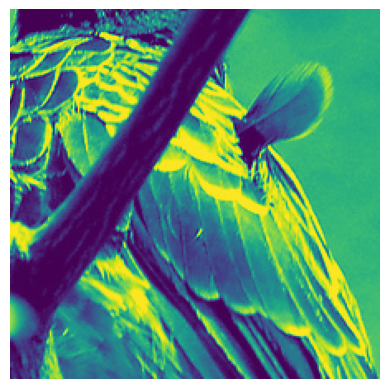

In [3]:
# Get a batch from the DataLoader
def show_image(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1, 2, 0))  # Convert to HWC
    plt.imshow(img)
    plt.axis('off')
    plt.show()


data_iter = iter(train_loader)  # Replace `train_loader` with your DataLoader
features, targets = next(data_iter)
print(targets.shape)
show_image(targets[0])  # Show the first image in the batch

In [4]:


# Example usage:
model = UpsampleModel()


input_tensor = torch.randn(1, 1024, 14, 14)  # Batch size = 1
output_tensor = model(input_tensor)
assert output_tensor.shape == torch.Size([1,1,224,224])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
params = count_parameters(model)
print("Total parametrs: ", params)
print("Params in samples : ", params / (224*224))

Total parametrs:  24511329
Params in samples :  488.5070352359694


In [5]:
criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

T_max = len(train_loader) * EPOCHS  # Total number of batches across all epochs

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max)

In [6]:
import torch


# Training loop
model.train()
model.to(device)
running_loss = 0.0
losses = []
for epoch in range(EPOCHS):
    for i, (features, target) in tqdm(enumerate(train_loader)):
        features = features.to(device)  # Move to device
        target = target.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Step the scheduler after each batch
        scheduler.step()

        # Log the running loss
        running_loss += loss.item()
        if i % LOSS_EVERY == LOSS_EVERY - 1:
            avg_loss = running_loss / LOSS_EVERY
            print(f"Epoch {epoch+1}, Batch {i+1}, LR: {scheduler.get_last_lr()[0]:.6f}, Loss: {avg_loss:.4f}")
            losses.append(avg_loss)
            running_loss = 0.0


0it [00:00, ?it/s]

1it [00:07,  7.25s/it]

2it [00:12,  5.89s/it]

3it [00:17,  5.40s/it]

4it [00:21,  5.09s/it]

5it [00:26,  4.96s/it]

Epoch 1, Batch 5, LR: 0.000050, Loss: 0.9114


6it [00:30,  4.83s/it]

7it [00:35,  4.78s/it]

8it [00:40,  4.80s/it]

9it [00:45,  4.76s/it]

10it [00:49,  4.71s/it]

Epoch 1, Batch 10, LR: 0.000050, Loss: 0.7217


11it [00:54,  4.80s/it]

12it [00:59,  4.81s/it]

13it [01:04,  4.74s/it]

14it [01:08,  4.73s/it]

15it [01:13,  4.71s/it]

Epoch 1, Batch 15, LR: 0.000050, Loss: 0.6613


16it [01:18,  4.65s/it]

17it [01:22,  4.63s/it]

18it [01:27,  4.61s/it]

19it [01:31,  4.62s/it]

20it [01:36,  4.58s/it]

Epoch 1, Batch 20, LR: 0.000050, Loss: 0.6374


21it [01:41,  4.65s/it]

22it [01:45,  4.63s/it]

23it [01:50,  4.62s/it]

24it [01:54,  4.58s/it]

25it [01:59,  4.59s/it]

Epoch 1, Batch 25, LR: 0.000050, Loss: 0.6140


26it [02:04,  4.61s/it]

27it [02:08,  4.60s/it]

28it [02:13,  4.60s/it]

29it [02:17,  4.59s/it]

30it [02:22,  4.57s/it]

Epoch 1, Batch 30, LR: 0.000050, Loss: 0.6102


31it [02:26,  4.56s/it]

32it [02:31,  4.58s/it]

33it [02:36,  4.57s/it]

34it [02:41,  4.71s/it]

35it [02:45,  4.74s/it]

Epoch 1, Batch 35, LR: 0.000049, Loss: 0.6023


36it [02:50,  4.71s/it]

37it [02:55,  4.66s/it]

38it [02:59,  4.63s/it]

39it [03:04,  4.71s/it]

40it [03:09,  4.72s/it]

Epoch 1, Batch 40, LR: 0.000049, Loss: 0.6020


41it [03:13,  4.64s/it]

42it [03:18,  4.61s/it]

43it [03:22,  4.57s/it]

44it [03:27,  4.57s/it]

45it [03:31,  4.57s/it]

Epoch 1, Batch 45, LR: 0.000049, Loss: 0.5869


46it [03:36,  4.60s/it]

47it [03:41,  4.61s/it]

48it [03:45,  4.65s/it]

49it [03:50,  4.68s/it]

50it [03:55,  4.63s/it]

Epoch 1, Batch 50, LR: 0.000049, Loss: 0.5929


51it [03:59,  4.61s/it]

52it [04:04,  4.56s/it]

53it [04:08,  4.59s/it]

54it [04:13,  4.65s/it]

55it [04:18,  4.62s/it]

Epoch 1, Batch 55, LR: 0.000049, Loss: 0.5892


56it [04:22,  4.66s/it]

57it [04:27,  4.66s/it]

58it [04:32,  4.66s/it]

59it [04:36,  4.62s/it]

60it [04:41,  4.65s/it]

Epoch 1, Batch 60, LR: 0.000048, Loss: 0.5800


61it [04:45,  4.60s/it]

62it [04:50,  4.59s/it]

63it [04:55,  4.59s/it]

64it [04:59,  4.58s/it]

65it [05:04,  4.58s/it]

Epoch 1, Batch 65, LR: 0.000048, Loss: 0.5915


66it [05:09,  4.68s/it]

67it [05:13,  4.65s/it]

68it [05:18,  4.64s/it]

69it [05:23,  4.68s/it]

70it [05:27,  4.65s/it]

Epoch 1, Batch 70, LR: 0.000048, Loss: 0.5838


71it [05:32,  4.63s/it]

72it [05:36,  4.60s/it]

73it [05:41,  4.61s/it]

74it [05:46,  4.67s/it]

75it [05:51,  4.71s/it]

Epoch 1, Batch 75, LR: 0.000047, Loss: 0.5821


76it [05:55,  4.69s/it]

77it [06:00,  4.62s/it]

78it [06:04,  4.64s/it]

79it [06:09,  4.65s/it]

80it [06:14,  4.65s/it]

Epoch 1, Batch 80, LR: 0.000047, Loss: 0.5861


81it [06:18,  4.63s/it]

82it [06:23,  4.67s/it]

83it [06:28,  4.65s/it]

84it [06:32,  4.60s/it]

85it [06:37,  4.63s/it]

Epoch 1, Batch 85, LR: 0.000047, Loss: 0.5812


86it [06:41,  4.58s/it]

87it [06:46,  4.59s/it]

88it [06:50,  4.58s/it]

89it [06:55,  4.57s/it]

90it [07:00,  4.68s/it]

Epoch 1, Batch 90, LR: 0.000046, Loss: 0.5885


91it [07:05,  4.65s/it]

92it [07:09,  4.63s/it]

93it [07:14,  4.61s/it]

94it [07:18,  4.62s/it]

95it [07:23,  4.66s/it]

Epoch 1, Batch 95, LR: 0.000046, Loss: 0.5817


96it [07:28,  4.66s/it]

97it [07:33,  4.70s/it]

98it [07:37,  4.68s/it]

99it [07:42,  4.66s/it]

100it [07:46,  4.67s/it]

Epoch 1, Batch 100, LR: 0.000045, Loss: 0.5835


101it [07:51,  4.65s/it]

102it [07:56,  4.66s/it]

103it [08:01,  4.69s/it]

104it [08:05,  4.66s/it]

105it [08:10,  4.66s/it]

Epoch 1, Batch 105, LR: 0.000045, Loss: 0.5754


106it [08:15,  4.69s/it]

107it [08:19,  4.63s/it]

108it [08:24,  4.60s/it]

109it [08:28,  4.55s/it]

110it [08:32,  4.48s/it]

Epoch 1, Batch 110, LR: 0.000044, Loss: 0.5772


111it [08:37,  4.43s/it]

112it [08:41,  4.45s/it]

113it [08:46,  4.48s/it]

114it [08:51,  4.60s/it]

115it [08:55,  4.66s/it]

Epoch 1, Batch 115, LR: 0.000044, Loss: 0.5821


116it [09:00,  4.66s/it]

117it [09:05,  4.65s/it]

118it [09:09,  4.63s/it]

119it [09:14,  4.64s/it]

120it [09:18,  4.62s/it]

Epoch 1, Batch 120, LR: 0.000043, Loss: 0.5786


121it [09:23,  4.62s/it]

122it [09:28,  4.61s/it]

123it [09:32,  4.60s/it]

124it [09:37,  4.60s/it]

125it [09:41,  4.61s/it]

Epoch 1, Batch 125, LR: 0.000043, Loss: 0.5771


126it [09:46,  4.59s/it]

127it [09:51,  4.66s/it]

128it [09:56,  4.69s/it]

129it [10:00,  4.64s/it]

130it [10:05,  4.64s/it]

Epoch 1, Batch 130, LR: 0.000042, Loss: 0.5867


131it [10:10,  4.69s/it]

132it [10:14,  4.72s/it]

133it [10:19,  4.75s/it]

134it [10:24,  4.77s/it]

135it [10:28,  4.69s/it]

Epoch 1, Batch 135, LR: 0.000042, Loss: 0.5787


136it [10:33,  4.70s/it]

137it [10:38,  4.66s/it]

138it [10:43,  4.69s/it]

139it [10:47,  4.67s/it]

140it [10:52,  4.60s/it]

Epoch 1, Batch 140, LR: 0.000041, Loss: 0.5797


141it [10:56,  4.60s/it]

142it [11:01,  4.57s/it]

143it [11:05,  4.59s/it]

144it [11:10,  4.60s/it]

145it [11:15,  4.61s/it]

Epoch 1, Batch 145, LR: 0.000040, Loss: 0.5815


146it [11:19,  4.61s/it]

147it [11:24,  4.60s/it]

148it [11:28,  4.60s/it]

149it [11:33,  4.59s/it]

150it [11:38,  4.67s/it]

Epoch 1, Batch 150, LR: 0.000040, Loss: 0.5802


151it [11:43,  4.69s/it]

152it [11:47,  4.66s/it]

153it [11:52,  4.64s/it]

154it [11:56,  4.66s/it]

155it [12:01,  4.63s/it]

Epoch 1, Batch 155, LR: 0.000039, Loss: 0.5820


156it [12:06,  4.69s/it]

157it [12:10,  4.62s/it]

158it [12:15,  4.62s/it]

159it [12:19,  4.59s/it]

160it [12:24,  4.59s/it]

Epoch 1, Batch 160, LR: 0.000038, Loss: 0.5787


161it [12:29,  4.61s/it]

162it [12:33,  4.61s/it]

163it [12:38,  4.55s/it]

164it [12:42,  4.58s/it]

165it [12:47,  4.60s/it]

Epoch 1, Batch 165, LR: 0.000038, Loss: 0.5860


166it [12:52,  4.65s/it]

167it [12:56,  4.64s/it]

168it [13:01,  4.63s/it]

169it [13:06,  4.64s/it]

170it [13:10,  4.64s/it]

Epoch 1, Batch 170, LR: 0.000037, Loss: 0.5828


171it [13:15,  4.64s/it]

172it [13:19,  4.63s/it]

173it [13:24,  4.67s/it]

174it [13:29,  4.70s/it]

175it [13:34,  4.67s/it]

Epoch 1, Batch 175, LR: 0.000036, Loss: 0.5778


176it [13:38,  4.64s/it]

177it [13:43,  4.68s/it]

178it [13:48,  4.67s/it]

179it [13:52,  4.63s/it]

180it [13:57,  4.68s/it]

Epoch 1, Batch 180, LR: 0.000036, Loss: 0.5838


181it [14:01,  4.62s/it]

182it [14:06,  4.62s/it]

183it [14:11,  4.67s/it]

184it [14:15,  4.66s/it]

185it [14:20,  4.65s/it]

Epoch 1, Batch 185, LR: 0.000035, Loss: 0.5815


186it [14:25,  4.69s/it]

187it [14:29,  4.66s/it]

188it [14:34,  4.65s/it]

189it [14:39,  4.59s/it]

190it [14:43,  4.66s/it]

Epoch 1, Batch 190, LR: 0.000034, Loss: 0.5702


191it [14:48,  4.59s/it]

192it [14:52,  4.51s/it]

193it [14:57,  4.50s/it]

194it [15:01,  4.51s/it]

195it [15:06,  4.52s/it]

Epoch 1, Batch 195, LR: 0.000033, Loss: 0.5809


196it [15:10,  4.54s/it]

197it [15:15,  4.69s/it]

198it [15:20,  4.66s/it]

199it [15:24,  4.62s/it]

200it [15:29,  4.64s/it]

Epoch 1, Batch 200, LR: 0.000033, Loss: 0.5798


201it [15:34,  4.81s/it]

202it [15:39,  4.70s/it]

203it [15:43,  4.68s/it]

204it [15:48,  4.72s/it]

205it [15:53,  4.67s/it]

Epoch 1, Batch 205, LR: 0.000032, Loss: 0.5819


206it [15:57,  4.60s/it]

207it [16:02,  4.59s/it]

208it [16:07,  4.65s/it]

209it [16:11,  4.69s/it]

210it [16:16,  4.71s/it]

Epoch 1, Batch 210, LR: 0.000031, Loss: 0.5843


211it [16:21,  4.75s/it]

212it [16:26,  4.76s/it]

213it [16:30,  4.74s/it]

214it [16:35,  4.70s/it]

215it [16:40,  4.66s/it]

Epoch 1, Batch 215, LR: 0.000030, Loss: 0.5884


216it [16:44,  4.61s/it]

217it [16:49,  4.62s/it]

218it [16:53,  4.66s/it]

219it [16:58,  4.64s/it]

220it [17:03,  4.61s/it]

Epoch 1, Batch 220, LR: 0.000030, Loss: 0.5682


221it [17:07,  4.64s/it]

222it [17:12,  4.62s/it]

223it [17:17,  4.64s/it]

224it [17:21,  4.59s/it]

225it [17:26,  4.60s/it]

Epoch 1, Batch 225, LR: 0.000029, Loss: 0.5815


226it [17:30,  4.63s/it]

227it [17:35,  4.63s/it]

228it [17:40,  4.63s/it]

229it [17:44,  4.67s/it]

230it [17:49,  4.69s/it]

Epoch 1, Batch 230, LR: 0.000028, Loss: 0.5765


231it [17:54,  4.67s/it]

232it [17:59,  4.73s/it]

233it [18:03,  4.66s/it]

234it [18:08,  4.67s/it]

235it [18:13,  4.72s/it]

Epoch 1, Batch 235, LR: 0.000027, Loss: 0.5864


236it [18:18,  4.84s/it]

237it [18:22,  4.77s/it]

238it [18:27,  4.71s/it]

239it [18:32,  4.69s/it]

240it [18:36,  4.74s/it]

Epoch 1, Batch 240, LR: 0.000027, Loss: 0.5801


241it [18:41,  4.66s/it]

242it [18:46,  4.66s/it]

243it [18:50,  4.60s/it]

244it [18:55,  4.58s/it]

245it [18:59,  4.61s/it]

Epoch 1, Batch 245, LR: 0.000026, Loss: 0.5718


246it [19:04,  4.61s/it]

247it [19:08,  4.61s/it]

248it [19:13,  4.59s/it]

249it [19:18,  4.58s/it]

250it [19:22,  4.57s/it]

Epoch 1, Batch 250, LR: 0.000025, Loss: 0.5742


251it [19:27,  4.57s/it]

252it [19:31,  4.56s/it]

253it [19:36,  4.61s/it]

254it [19:41,  4.68s/it]

255it [19:46,  4.72s/it]

Epoch 1, Batch 255, LR: 0.000024, Loss: 0.5821


256it [19:50,  4.63s/it]

257it [19:55,  4.64s/it]

258it [19:59,  4.61s/it]

259it [20:04,  4.59s/it]

260it [20:08,  4.60s/it]

Epoch 1, Batch 260, LR: 0.000023, Loss: 0.5731


261it [20:13,  4.60s/it]

262it [20:18,  4.60s/it]

263it [20:22,  4.61s/it]

264it [20:27,  4.62s/it]

265it [20:32,  4.62s/it]

Epoch 1, Batch 265, LR: 0.000023, Loss: 0.5752


266it [20:36,  4.61s/it]

267it [20:41,  4.65s/it]

268it [20:45,  4.64s/it]

269it [20:50,  4.60s/it]

270it [20:55,  4.58s/it]

Epoch 1, Batch 270, LR: 0.000022, Loss: 0.5794


271it [20:59,  4.59s/it]

272it [21:04,  4.61s/it]

273it [21:08,  4.57s/it]

274it [21:13,  4.63s/it]

275it [21:18,  4.61s/it]

Epoch 1, Batch 275, LR: 0.000021, Loss: 0.5785


276it [21:22,  4.63s/it]

277it [21:27,  4.63s/it]

278it [21:31,  4.62s/it]

279it [21:36,  4.61s/it]

280it [21:41,  4.60s/it]

Epoch 1, Batch 280, LR: 0.000020, Loss: 0.5761


281it [21:45,  4.67s/it]

282it [21:50,  4.66s/it]

283it [21:55,  4.70s/it]

284it [22:00,  4.73s/it]

285it [22:04,  4.69s/it]

Epoch 1, Batch 285, LR: 0.000020, Loss: 0.5764


286it [22:09,  4.66s/it]

287it [22:14,  4.67s/it]

288it [22:18,  4.65s/it]

289it [22:23,  4.70s/it]

290it [22:28,  4.70s/it]

Epoch 1, Batch 290, LR: 0.000019, Loss: 0.5785


291it [22:32,  4.64s/it]

292it [22:37,  4.65s/it]

293it [22:41,  4.64s/it]

294it [22:46,  4.60s/it]

295it [22:50,  4.58s/it]

Epoch 1, Batch 295, LR: 0.000018, Loss: 0.5747


296it [22:55,  4.63s/it]

297it [23:00,  4.62s/it]

298it [23:05,  4.68s/it]

299it [23:09,  4.64s/it]

300it [23:14,  4.61s/it]

Epoch 1, Batch 300, LR: 0.000017, Loss: 0.5825


301it [23:19,  4.75s/it]

302it [23:24,  4.74s/it]

303it [23:28,  4.72s/it]

304it [23:33,  4.65s/it]

305it [23:37,  4.66s/it]

Epoch 1, Batch 305, LR: 0.000017, Loss: 0.5787


306it [23:42,  4.72s/it]

307it [23:47,  4.70s/it]

308it [23:51,  4.66s/it]

309it [23:56,  4.65s/it]

310it [24:01,  4.59s/it]

Epoch 1, Batch 310, LR: 0.000016, Loss: 0.5788


311it [24:05,  4.61s/it]

312it [24:10,  4.60s/it]

313it [24:14,  4.59s/it]

314it [24:19,  4.65s/it]

315it [24:24,  4.62s/it]

Epoch 1, Batch 315, LR: 0.000015, Loss: 0.5752


316it [24:28,  4.63s/it]

317it [24:33,  4.68s/it]

318it [24:38,  4.73s/it]

319it [24:43,  4.72s/it]

320it [24:47,  4.75s/it]

Epoch 1, Batch 320, LR: 0.000014, Loss: 0.5787


321it [24:52,  4.77s/it]

322it [24:57,  4.73s/it]

323it [25:02,  4.69s/it]

324it [25:06,  4.65s/it]

325it [25:11,  4.67s/it]

Epoch 1, Batch 325, LR: 0.000014, Loss: 0.5760


326it [25:15,  4.67s/it]

327it [25:20,  4.68s/it]

328it [25:25,  4.63s/it]

329it [25:29,  4.68s/it]

330it [25:34,  4.67s/it]

Epoch 1, Batch 330, LR: 0.000013, Loss: 0.5770


331it [25:39,  4.61s/it]

332it [25:43,  4.59s/it]

333it [25:48,  4.62s/it]

334it [25:52,  4.63s/it]

335it [25:57,  4.64s/it]

Epoch 1, Batch 335, LR: 0.000012, Loss: 0.5789


336it [26:02,  4.66s/it]

337it [26:07,  4.72s/it]

338it [26:11,  4.65s/it]

339it [26:16,  4.68s/it]

340it [26:21,  4.68s/it]

Epoch 1, Batch 340, LR: 0.000012, Loss: 0.5854


341it [26:25,  4.67s/it]

342it [26:30,  4.65s/it]

343it [26:35,  4.69s/it]

344it [26:39,  4.72s/it]

345it [26:44,  4.69s/it]

Epoch 1, Batch 345, LR: 0.000011, Loss: 0.5842


346it [26:49,  4.69s/it]

347it [26:53,  4.65s/it]

348it [26:58,  4.62s/it]

349it [27:03,  4.68s/it]

350it [27:07,  4.64s/it]

Epoch 1, Batch 350, LR: 0.000010, Loss: 0.5718


351it [27:12,  4.69s/it]

352it [27:17,  4.70s/it]

353it [27:21,  4.66s/it]

354it [27:26,  4.64s/it]

355it [27:30,  4.63s/it]

Epoch 1, Batch 355, LR: 0.000010, Loss: 0.5799


356it [27:35,  4.61s/it]

357it [27:40,  4.61s/it]

358it [27:45,  4.70s/it]

359it [27:49,  4.67s/it]

360it [27:54,  4.62s/it]

Epoch 1, Batch 360, LR: 0.000009, Loss: 0.5758


361it [27:58,  4.62s/it]

362it [28:03,  4.59s/it]

363it [28:07,  4.58s/it]

364it [28:12,  4.60s/it]

365it [28:17,  4.58s/it]

Epoch 1, Batch 365, LR: 0.000008, Loss: 0.5777


366it [28:21,  4.60s/it]

367it [28:26,  4.62s/it]

368it [28:31,  4.62s/it]

369it [28:36,  4.74s/it]

370it [28:40,  4.69s/it]

Epoch 1, Batch 370, LR: 0.000008, Loss: 0.5737


371it [28:45,  4.65s/it]

372it [28:49,  4.64s/it]

373it [28:54,  4.72s/it]

374it [28:59,  4.79s/it]

375it [29:04,  4.73s/it]

Epoch 1, Batch 375, LR: 0.000007, Loss: 0.5708


376it [29:08,  4.67s/it]

377it [29:13,  4.67s/it]

378it [29:17,  4.64s/it]

379it [29:22,  4.59s/it]

380it [29:27,  4.58s/it]

Epoch 1, Batch 380, LR: 0.000007, Loss: 0.5763


381it [29:31,  4.66s/it]

382it [29:36,  4.58s/it]

383it [29:40,  4.56s/it]

384it [29:45,  4.62s/it]

385it [29:50,  4.59s/it]

Epoch 1, Batch 385, LR: 0.000006, Loss: 0.5695


386it [29:54,  4.61s/it]

387it [29:59,  4.61s/it]

388it [30:04,  4.69s/it]

389it [30:08,  4.66s/it]

390it [30:13,  4.68s/it]

Epoch 1, Batch 390, LR: 0.000006, Loss: 0.5732


391it [30:18,  4.64s/it]

392it [30:22,  4.65s/it]

393it [30:27,  4.69s/it]

394it [30:32,  4.69s/it]

395it [30:36,  4.66s/it]

Epoch 1, Batch 395, LR: 0.000005, Loss: 0.5853


396it [30:41,  4.66s/it]

397it [30:46,  4.67s/it]

398it [30:50,  4.65s/it]

399it [30:55,  4.62s/it]

400it [30:59,  4.57s/it]

Epoch 1, Batch 400, LR: 0.000005, Loss: 0.5744


401it [31:04,  4.60s/it]

402it [31:09,  4.61s/it]

403it [31:13,  4.57s/it]

404it [31:18,  4.57s/it]

405it [31:22,  4.58s/it]

Epoch 1, Batch 405, LR: 0.000004, Loss: 0.5707


406it [31:27,  4.57s/it]

407it [31:31,  4.61s/it]

408it [31:36,  4.66s/it]

409it [31:41,  4.65s/it]

410it [31:46,  4.67s/it]

Epoch 1, Batch 410, LR: 0.000004, Loss: 0.5783


411it [31:50,  4.65s/it]

412it [31:55,  4.64s/it]

413it [31:59,  4.65s/it]

414it [32:04,  4.66s/it]

415it [32:09,  4.60s/it]

Epoch 1, Batch 415, LR: 0.000003, Loss: 0.5789


416it [32:13,  4.61s/it]

417it [32:18,  4.65s/it]

418it [32:23,  4.62s/it]

419it [32:27,  4.61s/it]

420it [32:32,  4.58s/it]

Epoch 1, Batch 420, LR: 0.000003, Loss: 0.5771


421it [32:36,  4.59s/it]

422it [32:41,  4.57s/it]

423it [32:46,  4.62s/it]

424it [32:50,  4.58s/it]

425it [32:55,  4.59s/it]

Epoch 1, Batch 425, LR: 0.000003, Loss: 0.5756


426it [32:59,  4.57s/it]

427it [33:04,  4.57s/it]

428it [33:09,  4.67s/it]

429it [33:13,  4.66s/it]

430it [33:18,  4.71s/it]

Epoch 1, Batch 430, LR: 0.000002, Loss: 0.5756


431it [33:23,  4.64s/it]

432it [33:27,  4.57s/it]

433it [33:32,  4.58s/it]

434it [33:36,  4.56s/it]

435it [33:41,  4.57s/it]

Epoch 1, Batch 435, LR: 0.000002, Loss: 0.5782


436it [33:45,  4.59s/it]

437it [33:50,  4.57s/it]

438it [33:55,  4.60s/it]

439it [33:59,  4.56s/it]

440it [34:03,  4.55s/it]

Epoch 1, Batch 440, LR: 0.000002, Loss: 0.5737


441it [34:08,  4.58s/it]

442it [34:13,  4.60s/it]

443it [34:17,  4.60s/it]

444it [34:22,  4.60s/it]

445it [34:27,  4.66s/it]

Epoch 1, Batch 445, LR: 0.000001, Loss: 0.5696


446it [34:31,  4.66s/it]

447it [34:36,  4.70s/it]

448it [34:41,  4.74s/it]

449it [34:46,  4.70s/it]

450it [34:50,  4.72s/it]

Epoch 1, Batch 450, LR: 0.000001, Loss: 0.5777


451it [34:55,  4.70s/it]

452it [35:00,  4.67s/it]

453it [35:04,  4.65s/it]

454it [35:09,  4.67s/it]

455it [35:14,  4.65s/it]

Epoch 1, Batch 455, LR: 0.000001, Loss: 0.5748


456it [35:18,  4.66s/it]

457it [35:23,  4.67s/it]

458it [35:28,  4.63s/it]

459it [35:32,  4.60s/it]

460it [35:37,  4.58s/it]

Epoch 1, Batch 460, LR: 0.000001, Loss: 0.5738


461it [35:41,  4.58s/it]

462it [35:46,  4.57s/it]

463it [35:50,  4.57s/it]

464it [35:55,  4.60s/it]

465it [36:00,  4.59s/it]

Epoch 1, Batch 465, LR: 0.000001, Loss: 0.5717


466it [36:04,  4.57s/it]

467it [36:09,  4.58s/it]

468it [36:13,  4.59s/it]

469it [36:18,  4.60s/it]

470it [36:22,  4.56s/it]

Epoch 1, Batch 470, LR: 0.000000, Loss: 0.5775


471it [36:27,  4.59s/it]

472it [36:32,  4.59s/it]

473it [36:36,  4.60s/it]

474it [36:41,  4.73s/it]

475it [36:46,  4.73s/it]

Epoch 1, Batch 475, LR: 0.000000, Loss: 0.5808


476it [36:51,  4.71s/it]

477it [36:55,  4.66s/it]

478it [37:00,  4.64s/it]

479it [37:04,  4.61s/it]

480it [37:09,  4.66s/it]

Epoch 1, Batch 480, LR: 0.000000, Loss: 0.5805


481it [37:14,  4.60s/it]

482it [37:18,  4.56s/it]

483it [37:23,  4.59s/it]

484it [37:27,  4.63s/it]

485it [37:32,  4.65s/it]

Epoch 1, Batch 485, LR: 0.000000, Loss: 0.5803


486it [37:37,  4.59s/it]

487it [37:41,  4.58s/it]

488it [37:46,  4.67s/it]

489it [37:50,  4.61s/it]

490it [37:55,  4.69s/it]

Epoch 1, Batch 490, LR: 0.000000, Loss: 0.5751


491it [38:00,  4.67s/it]

492it [38:04,  4.63s/it]

493it [38:09,  4.62s/it]

494it [38:14,  4.66s/it]

495it [38:18,  4.63s/it]

Epoch 1, Batch 495, LR: 0.000000, Loss: 0.5713


496it [38:23,  4.68s/it]

497it [38:28,  4.69s/it]

498it [38:32,  4.64s/it]

499it [38:37,  4.62s/it]

500it [38:42,  4.62s/it]

500it [38:42,  4.64s/it]

Epoch 1, Batch 500, LR: 0.000000, Loss: 0.5792


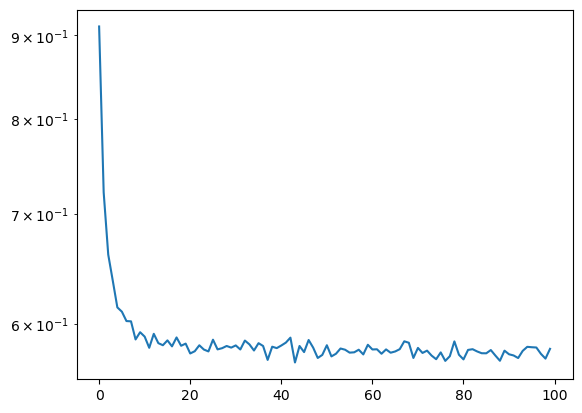

In [7]:
# Plot losses
plt.plot(losses)
plt.yscale('log')
# set maximum y to 

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:03<00:59,  3.15s/it]

 10%|█         | 2/20 [00:06<00:56,  3.16s/it]

 15%|█▌        | 3/20 [00:09<00:54,  3.22s/it]

 20%|██        | 4/20 [00:12<00:51,  3.19s/it]

 25%|██▌       | 5/20 [00:16<00:48,  3.24s/it]

 30%|███       | 6/20 [00:19<00:44,  3.15s/it]

 35%|███▌      | 7/20 [00:22<00:41,  3.18s/it]

 40%|████      | 8/20 [00:25<00:37,  3.14s/it]

 45%|████▌     | 9/20 [00:28<00:35,  3.19s/it]

 50%|█████     | 10/20 [00:32<00:32,  3.25s/it]

 55%|█████▌    | 11/20 [00:35<00:30,  3.34s/it]

 60%|██████    | 12/20 [00:38<00:26,  3.26s/it]

 65%|██████▌   | 13/20 [00:41<00:22,  3.25s/it]

 70%|███████   | 14/20 [00:45<00:19,  3.30s/it]

 75%|███████▌  | 15/20 [00:48<00:16,  3.27s/it]

 80%|████████  | 16/20 [00:51<00:12,  3.24s/it]

 85%|████████▌ | 17/20 [00:54<00:09,  3.18s/it]

 90%|█████████ | 18/20 [00:57<00:06,  3.15s/it]

 95%|█████████▌| 19/20 [01:00<00:03,  3.07s/it]

100%|██████████| 20/20 [01:03<00:00,  3.02s/it]

100%|██████████| 20/20 [01:03<00:00,  3.18s/it]

Test Loss: 0.5642


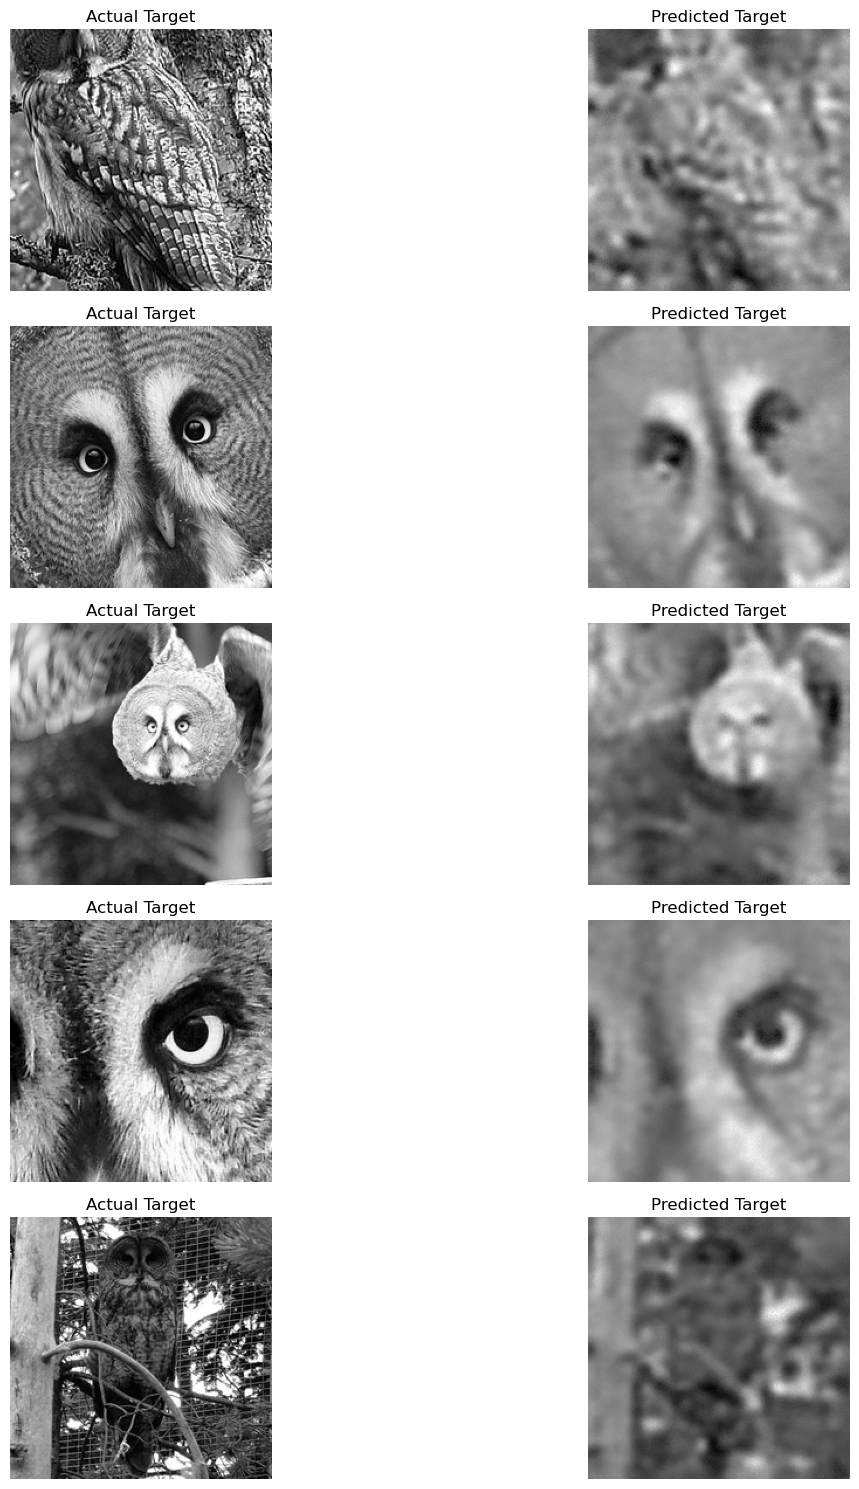

In [8]:
import matplotlib.pyplot as plt

def evaluate_partial_model(model, test_loader, device, max_batches=10_000):
    model.eval()
    test_loss = 0.0
    all_targets = []
    all_predictions = []

    num_batches = min(max_batches, len(test_loader)) 
    processed_batches = 0

    with torch.no_grad():
        for features, target in tqdm(test_loader):
            if processed_batches >= num_batches:
                break

            features = features.to(device)
            target = target.to(device)

            # Predict
            predictions = model(features)

            loss = criterion(predictions, target)
            test_loss += loss.item()

            # Store for plotting
            all_targets.append(target.cpu())
            all_predictions.append(predictions.cpu())

            processed_batches += 1

    test_loss /= processed_batches
    all_targets = torch.cat(all_targets, dim=0)
    all_predictions = torch.cat(all_predictions, dim=0)

    return test_loss, all_targets, all_predictions

# Evaluate on the first 10% of the test dataset
test_loss_partial, partial_targets, partial_predictions = evaluate_partial_model(model, test_loader, device)
print(f"Test Loss: {test_loss_partial:.4f}")

def plot_examples(targets, predictions, num_examples=5):
    plt.figure(figsize=(15, num_examples * 3))
    for i in range(num_examples):
        # Plot the actual target
        plt.subplot(num_examples, 2, 2 * i + 1)
        plt.imshow(targets[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Actual Target")
        plt.axis('off')

        # Plot the predicted target
        plt.subplot(num_examples, 2, 2 * i + 2)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove extra dimension
        plt.title("Predicted Target")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot Examples
num_examples = 5  # Number of examples to visualize
plot_examples(partial_targets[:num_examples].cpu().numpy(), partial_predictions[:num_examples].cpu().numpy())


In [9]:
print(partial_predictions.min(), partial_predictions.max())
print(partial_targets.min(), partial_targets.max())

tensor(-6.6352) tensor(6.5717)
tensor(0.) tensor(0.9999)


In [10]:
name_extra = os.environ['SLURM_JOB_ID'] if 'SLURM_JOB_ID' in os.environ else ''
name = join(os.environ['MODELS_PATH'], "mlp" + name_extra + ".pt")
torch.save(model, name)
print("Model saved to ", name)

Model saved to 

 /scratch/izar/vanousek/cs-433-project/models/mlp2495919.pt
